# PyTorch EO Semantic Segmentation Example
## Step 2: Creating training data tensors
*Rob Knapen, Wageningen Environmental Research*

This notebook creates a HDF5 input file that contains all the training data for a SegNet model that is used in a next notebook.

In [1]:
# connect to Google Drive for access to the training data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Note: To see a folder that is shared with you, you need to create
#   a shortcut for it on your Google Drive before it you can access
#   it here in CoLab.

# expect a data / tiles / temp folder with a cleaned and prepared set
# of training images. The images need to be split into train, test
# and val folders.
!ls '/content/drive/MyDrive/AI_WENR/data/tiles/temp/'

test  train  val


In [3]:
# setup paths to the data
import os
import shutil
from glob import glob

# construct the paths to the training data
content_root_folder = os.path.join('/content', 'drive', 'MyDrive', 'AI_WENR', 'data')

# origin raw input sources for features and labels
aoi_observations_file = os.path.join(content_root_folder, 'processed', 'sent2_2018_seasons_10m_7x4bands.tif')
aoi_groundtruth_file = os.path.join(content_root_folder, 'processed', 'gewaspercelen_2018_ras10m_subNO_76_classes.tif')

# HDF5 output file to create
hdf5_file = os.path.join(content_root_folder, 'inputs', 'crops_training_data_s2_10m_2018seasons_224x224x28_76cat.hdf5')

# image tiles to process
tiles_temp_folder = os.path.join(content_root_folder, 'tiles', 'temp')
tiles_train_folder = os.path.join(tiles_temp_folder, 'train')
tiles_val_folder = os.path.join(tiles_temp_folder, 'val')
tiles_test_folder = os.path.join(tiles_temp_folder, 'test')

# expected names of the sub folders
features_subfolder = 'features'
labels_subfolder = 'labels'

# info on feature images to expect
base_feature_image_name = 'sent2_2018_seasons_10m_7x4bands_224px'
expected_feature_image_size_pixels = 224

# info on label images to expect
base_label_image_name = 'parcels_2018_10m_coded_76_224px'
expected_label_image_size_pixels = 224

# file with information about the encoding used for the labels
codes_folder = os.path.join(content_root_folder, 'codes')
codes_file = os.path.join(codes_folder, 'cell_value_to_crop_info_76_classes.csv')

In [4]:
# local install of the rasterio library
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [5]:
# import some packages for GeoTIFF processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import rasterio

In [6]:
# collect all (remaining) available images
# (some jargon switch here, obs = observations, gt = ground truths)
from glob import glob

all_train_obs_files = sorted(glob(os.path.join(tiles_train_folder, features_subfolder, '*.tif')))
all_train_gt_files  = sorted(glob(os.path.join(tiles_train_folder, labels_subfolder, '*.tif')))
all_train_files     = list(zip(sorted(all_train_obs_files), sorted(all_train_gt_files)))

all_test_obs_files = sorted(glob(os.path.join(tiles_val_folder, features_subfolder, '*.tif')))
all_test_gt_files  = sorted(glob(os.path.join(tiles_val_folder, labels_subfolder, '*.tif')))
all_test_files     = list(zip(sorted(all_test_obs_files), sorted(all_test_gt_files)))

n_train = len(all_train_files)
n_test  = len(all_test_files)

print('Found %d training image pairs and %d test image pairs' % (n_train, n_test))

Found 151 training image pairs and 43 test image pairs


In [7]:
 # get statistics for all bands from the source image
aoi_obs = rasterio.open(aoi_observations_file)

print('Area of interest width   :', aoi_obs.width)
print('Area of interest height  :', aoi_obs.height)
print('Area of interest bounds  :', aoi_obs.bounds)
print('Area of interest indexes :', aoi_obs.indexes)

# get statistics per band for the aoi, later used for scaling and centering the tensors
from rasterio.rio.insp import stats

def parse_stats(aoi_obs):
    stats_ds = stats(aoi_obs)
    return {'min':stats_ds.min, 'max':stats_ds.max, 'mean':stats_ds.mean}

overall_band_stats = [parse_stats(aoi_obs.read(i)) for i in aoi_obs.indexes]
overall_band_stats

Area of interest width   : 5490
Area of interest height  : 2170
Area of interest bounds  : BoundingBox(left=674900.0, bottom=5832260.0, right=729800.0, top=5853960.0)
Area of interest indexes : (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28)


[{'max': 18803, 'mean': 607.3391804118087, 'min': 0},
 {'max': 17742, 'mean': 706.57445879815, 'min': 0},
 {'max': 16911, 'mean': 719.018369301537, 'min': 0},
 {'max': 16096, 'mean': 2374.1288598457186, 'min': 0},
 {'max': 19135, 'mean': 598.1018728647814, 'min': 0},
 {'max': 17927, 'mean': 736.3487095095397, 'min': 0},
 {'max': 17077, 'mean': 891.5888278646555, 'min': 0},
 {'max': 16199, 'mean': 2330.774305608018, 'min': 0},
 {'max': 17477, 'mean': 616.3851135285773, 'min': 0},
 {'max': 16813, 'mean': 899.7599559316059, 'min': 0},
 {'max': 16203, 'mean': 856.2919832456163, 'min': 0},
 {'max': 15558, 'mean': 3135.4466562581315, 'min': 0},
 {'max': 18048, 'mean': 454.27359228761134, 'min': 0},
 {'max': 16736, 'mean': 699.8448857159646, 'min': 0},
 {'max': 16152, 'mean': 567.8964401970907, 'min': 0},
 {'max': 15568, 'mean': 3510.7903752108987, 'min': 0},
 {'max': 17712, 'mean': 501.9185669797621, 'min': 0},
 {'max': 16752, 'mean': 788.7704425306171, 'min': 0},
 {'max': 16144, 'mean': 794

In [8]:
# function to normalize each band
def normalize(obs_ds):
    for b in range(obs_ds.shape[0]):
        b_max = overall_band_stats[b]['max']
        obs_ds[b] /= b_max

In [9]:
obs_file, gt_file = all_train_files[1]
obs_ds = rasterio.open(obs_file).read().astype('float32')
obs_ds.shape

(28, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


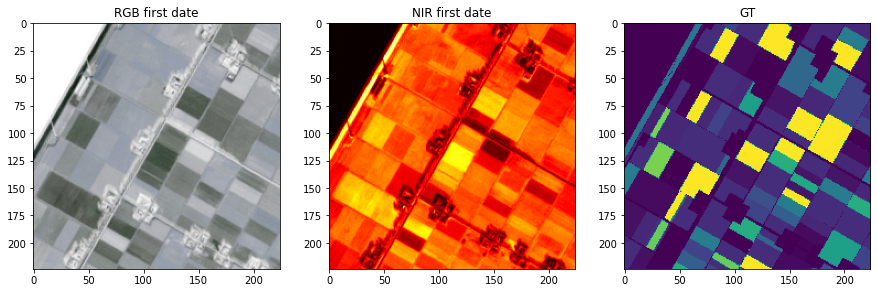

In [10]:
 # try an example
obs_file, gt_file = all_train_files[1]

obs_ds = rasterio.open(obs_file).read().astype('float32')
gt_ds  = rasterio.open(gt_file).read(1).astype('int16')

normalize(obs_ds)

# plot an example (RGB + NIR of first date)
tile = obs_ds[0:4,:,:].transpose((1,2,0))
tile *= 2.6 # beef up the RGB image for display

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1, aspect='equal')
ax.set(title='RGB first date')
ax.imshow(tile);

ax = fig.add_subplot(1, 3, 2, aspect='equal')
ax.set(title='NIR first date')
ax.imshow(tile[:,:,3], cmap='hot');

ax = fig.add_subplot(1, 3, 3, aspect='equal')
ax.set(title='GT')
ax.imshow(gt_ds, cmap='viridis');

In [11]:
# process all available train and test images and bundle them into
# a single HDF5 archive file for later use
hdf_file = h5py.File(hdf5_file, "w")

# add metadata
hdf_file.attrs['title'] = 'Crop classification training data set'
hdf_file.attrs['description'] = 'This data set is intended for training deep learning models for crop classification.'
hdf_file.attrs['spatial_resolution'] = '10x10m grid cells'
hdf_file.attrs['spatial_extent'] = 'Sample area around the Noordoost polder in The Netherlands.'
hdf_file.attrs['observations'] = '4 Bands (blue, green, red, nir) of 7 seasonal Sentinel 2 images, from 2018.'
hdf_file.attrs['observations_shape'] = '28,224,224; scaled [0-1], float32'
hdf_file.attrs['ground_truth'] = 'Encoded crop types for fields according to the RVO registration in 2018.'
hdf_file.attrs['ground_truth_shape'] = '1,224,224; 76 classes, int16'

# set up the datasets
train_obs_ds = hdf_file.create_dataset("train_observation", (n_train, 224, 224, 28), dtype='f4')
train_gt_ds  = hdf_file.create_dataset("train_groundtruth", (n_train, 224, 224), dtype='i')
test_obs_ds = hdf_file.create_dataset("test_observation", (n_test, 224, 224, 28), dtype='f4')
test_gt_ds  = hdf_file.create_dataset("test_groundtruth", (n_test, 224, 224), dtype='i')

# add training data
for idx, (obs_file, gt_file) in enumerate(all_train_files):
    obs_ds = rasterio.open(obs_file).read().astype('float32')
    normalize(obs_ds)
    obs_ds = obs_ds.transpose((1,2,0))
    train_obs_ds[idx] = obs_ds
    gt_ds  = rasterio.open(gt_file).read(1).astype('int16')
    train_gt_ds[idx] = gt_ds

# add test data
for idx, (obs_file, gt_file) in enumerate(all_test_files):
    obs_ds = rasterio.open(obs_file).read().astype('float32')
    normalize(obs_ds)
    obs_ds = obs_ds.transpose((1,2,0))
    test_obs_ds[idx] = obs_ds
    gt_ds  = rasterio.open(gt_file).read(1).astype('int16')
    test_gt_ds[idx] = gt_ds

hdf_file.close()

In [12]:
# open the file for reading as a test
data_file = h5py.File(hdf5_file, "r")

print("(Attribute, Value:)");
for item in data_file.attrs.items():
    print(item);

train_obs = data_file['train_observation'][:]
train_gt = data_file['train_groundtruth'][:]
test_obs = data_file['test_observation'][:]
test_gt = data_file['test_groundtruth'][:]
n_train = train_obs.shape[0]
n_test = test_obs.shape[0]

print("%d tiles for training, %d tiles for testing" % (n_train, n_test))

data_file.close()

(Attribute, Value:)
('description', 'This data set is intended for training deep learning models for crop classification.')
('ground_truth', 'Encoded crop types for fields according to the RVO registration in 2018.')
('ground_truth_shape', '1,224,224; 76 classes, int16')
('observations', '4 Bands (blue, green, red, nir) of 7 seasonal Sentinel 2 images, from 2018.')
('observations_shape', '28,224,224; scaled [0-1], float32')
('spatial_extent', 'Sample area around the Noordoost polder in The Netherlands.')
('spatial_resolution', '10x10m grid cells')
('title', 'Crop classification training data set')
151 tiles for training, 43 tiles for testing
